<a href="https://colab.research.google.com/github/MichelangeloConserva/statistical-challenge/blob/main/predictive_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Import
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import gaussian_kde, norm, multivariate_normal
from statsmodels.distributions.copula.elliptical import GaussianCopula
from tqdm import trange

np.random.seed(42)

def plot_samples(posterior_mean_trajs, mean, sigma_squared, final_posterior_mean):
    fig, axes = plt.subplots(1, 2, figsize=plt.figaspect(0.5), sharey=True)
    for t in posterior_mean_trajs:
        axes[0].plot(t)
    axes[0].set_xlabel("Forward step")
    axes[0].set_ylabel("Posterior mean")
    nn = norm(mean, sigma_squared**0.5)
    x = np.linspace(nn.ppf(0.0005), nn.ppf(1 - 0.0005), 200)
    axes[1].set_xlabel("Density")
    axes[1].plot(nn.pdf(x), x, color="black", label="True posterior density")
    axes[1].plot(gaussian_kde(final_posterior_mean)(x), x, label="KDE from sampling")
    plt.legend()
    plt.tight_layout()
    plt.show()

100%|██████████| 500/500 [00:01<00:00, 362.21it/s]


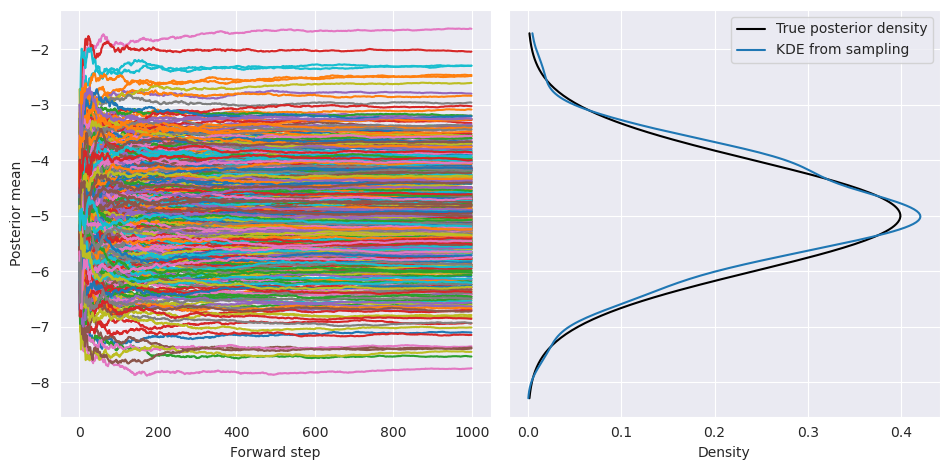

In [2]:
# @title Posterior sampling through sequential imputation
N = 1000  # @param {type:"slider", min:100, max:2000, step:10}
B = 500  # @param {type:"slider", min:100, max:2000, step:10}
observation_noise = 2  # @param {type:"slider", min:0.1, max:10, step:0.1}
initial_posterior_mean = -5  # @param {type:"slider", min:-10, max:10, step:0.5}
initial_posterior_sigma_squared = 1  # @param {type:"slider", min:0.1, max:10, step:0.1}

final_posterior_mean = []
posterior_mean_trajs = []
samples = []
for b in trange(B):
    copula_num = 0
    theta_n = initial_posterior_mean
    sigma_squared_n = initial_posterior_sigma_squared
    y_b = []

    posterior_mean_traj = []
    for i in range(N):
        y = np.random.normal(theta_n, (observation_noise + sigma_squared_n) ** 0.5)
        y_b.append(y)
        copula_num = len(y_b)
        sigma_squared_n = (
            1 / initial_posterior_sigma_squared + copula_num / observation_noise
        ) ** -1
        theta_n = (
            initial_posterior_mean / initial_posterior_sigma_squared
            + sum(y_b) / observation_noise
        ) * sigma_squared_n
        posterior_mean_traj.append(theta_n)
    final_posterior_mean.append(posterior_mean_traj[-1])
    posterior_mean_trajs.append(posterior_mean_traj)
    samples.append(y_b)

plot_samples(
    posterior_mean_trajs,
    initial_posterior_mean,
    initial_posterior_sigma_squared,
    final_posterior_mean,
)

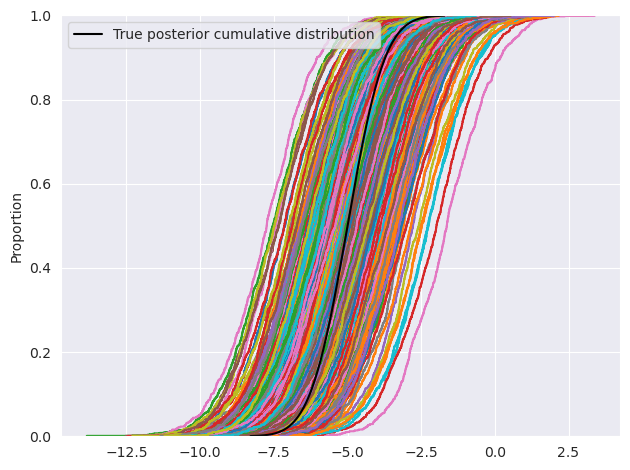

In [3]:
# @title Plotting empirical cumulative distribution obtained from imputing procedure
nn = norm(initial_posterior_mean, initial_posterior_sigma_squared**0.5)
x = np.linspace(nn.ppf(0.0005), nn.ppf(1 - 0.0005), 200)
for y_b in samples:
    sns.ecdfplot(y_b)
plt.plot(x, nn.cdf(x), color="black", label="True posterior cumulative distribution")
plt.legend()
plt.tight_layout()
plt.show()

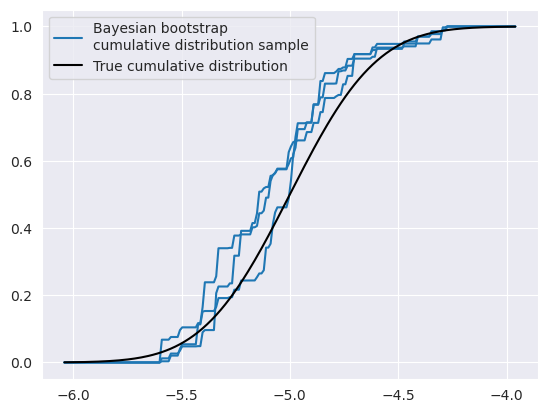

In [4]:
#@title Bayesian bootstrapping of normal distribution
N = 50  # @param {type:"slider", min:10, max:500, step:5}
mean = -5  # @param {type:"slider", min:-10, max:10, step:0.5}
sigma_squared = 0.1  # @param {type:"slider", min:0.1, max:10, step:0.1}
num_samples = 3  # @param {type:"slider", min:1, max:10, step:1}

# True samples
y_n = np.random.normal(mean, sigma_squared**0.5, N)

# Choosing points for plotting
nn = norm(mean, sigma_squared**0.5)
y = np.linspace(nn.ppf(0.0005), nn.ppf(1 - 0.0005), 200)

# BB samples
bb_samples = []
for _ in range(num_samples):
    w = np.random.dirichlet([1] * N)
    bb_sample = (w.reshape(-1, 1) * (y_n.reshape(-1, 1) <= y.reshape(1, -1))).sum(0)
    bb_samples.append(bb_sample)

for i, bb_sample in enumerate(bb_samples):
    plt.plot(
        y,
        bb_sample,
        label="Bayesian bootstrap\ncumulative distribution sample" if i == 0 else None,
        color="tab:blue",
    )
plt.plot(y, nn.cdf(y), color="black", label="True cumulative distribution")
plt.legend()
plt.show()

100%|██████████| 200/200 [00:00<00:00, 619.22it/s]


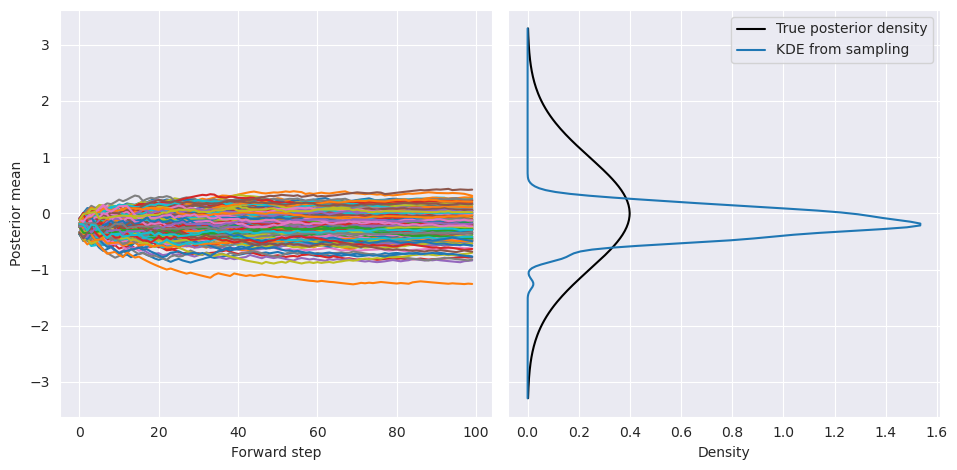

In [5]:
#@title Bayesian bootstrapping of normal distribution
N = 100  # @param {type:"slider", min:10, max:500, step:5}
B = 200  # @param {type:"slider", min:10, max:500, step:5}
copula_num = 10 # @param {type:"slider", min:5, max:100, step:5}
mean = 0.  # @param {type:"slider", min:-5., max:5, step:0.1}
sigma_squared = 1. # @param {type:"slider", min:.1, max:3, step:0.1}

y_1n = np.random.normal(mean, sigma_squared ** 0.5, copula_num)

final_posterior_mean = []
posterior_mean_trajs = []
samples = []
for b in trange(B):
    y_1N = list(y_1n)
    posterior_mean_traj = []
    for i in range(N):
        y_1N.append(np.random.choice(y_1N))
        final_mean = np.mean(y_1N)
        posterior_mean_traj.append(final_mean)
    final_posterior_mean.append(posterior_mean_traj[-1])
    posterior_mean_trajs.append(posterior_mean_traj)
    samples.append(y_1N)

# The main problem here is that the naive empirical predictive cannot sample anything different from what is present
# in the initial sample y_1n. In other words, the predictive distribution has atomic support on the observations y_1n,
# which is problematic if the underlying distribution (in this case the Normal distribution) has continuous support.
plot_samples(posterior_mean_trajs, mean, sigma_squared, final_posterior_mean)

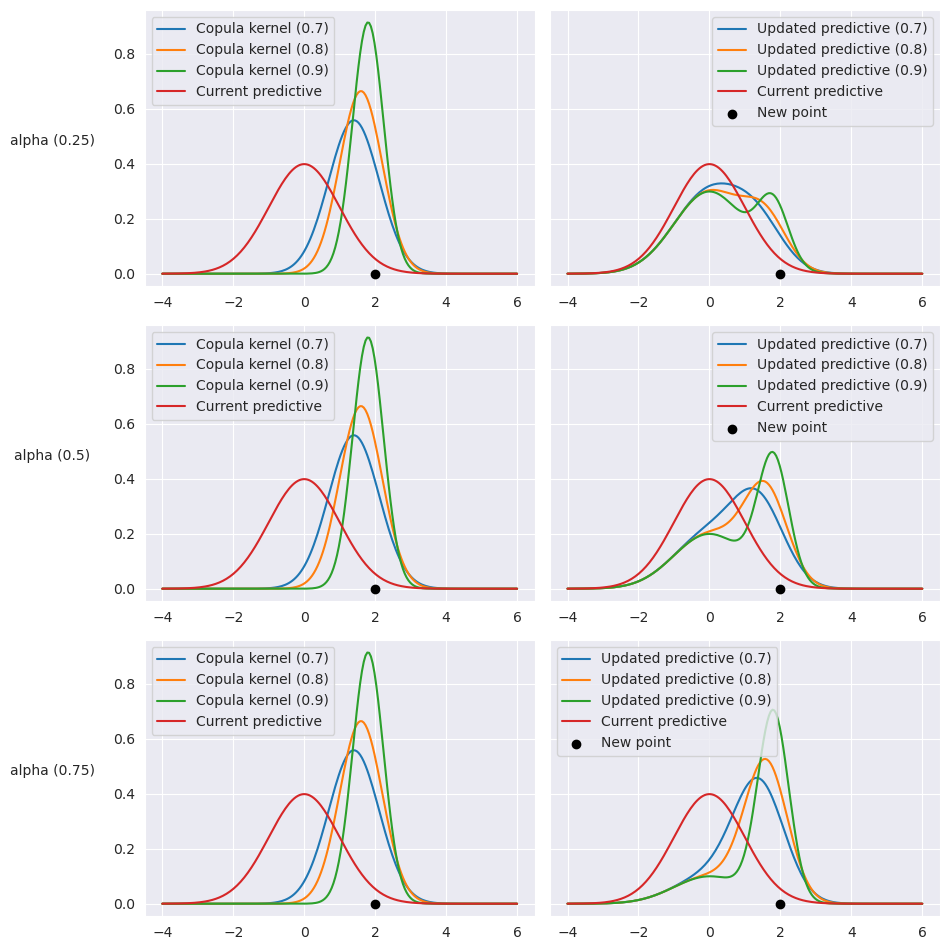

In [6]:
#@title Gaussian bivariate copula update
B = 200  # @param {type:"slider", min:10, max:500, step:5}

p_i = norm()
y = np.linspace(-4, 6, B)

fig, axes = plt.subplots(3, 2, figsize=2 * plt.figaspect(1), sharey=True)
for i, alpha in enumerate([0.25, 0.5, 0.75]):
    ax1, ax2 = axes[i]
    ax1.set_ylabel(f"alpha ({alpha})" + " " * 25, rotation=360)

    u = p_i.cdf(y)
    p_i_y = p_i.pdf(y)

    # Sampling new data point
    y_ip1 = 2.0
    v = p_i.cdf(y_ip1)
    # P_i_yp1 = np.random.rand()  # or equivalently sampling random probability

    # Copula inputs
    phi_inv_u = norm.ppf(u)
    phi_inv_v = norm.ppf(v)

    # Copula denominator
    copula_den = norm.pdf(phi_inv_u) * norm.pdf(phi_inv_v)

    for rho in [0.7, 0.8, 0.9]:

        # Covariance matrix
        cov = (rho * np.eye(2))[::-1] + np.eye(2)

        # Copula numerator
        copula_num = multivariate_normal(cov=cov).pdf(
            np.vstack((phi_inv_u, np.tile(phi_inv_v, len(y)))).T
        )

        # Copula kernel
        c_rho = copula_num / copula_den

        ax1.plot(y, p_i_y * c_rho, label=f"Copula kernel ({rho})")
        ax2.plot(
            y,
            (1 - alpha) * p_i_y + alpha * p_i_y * c_rho,
            label=f"Updated predictive ({rho})",
        )
    ax1.plot(y, p_i_y, label="Current predictive")
    ax2.plot(y, p_i_y, label="Current predictive")
    ax1.scatter(y_ip1, 0, color="black")
    ax2.scatter(y_ip1, 0, color="black", label="New point")
    ax1.legend()
    ax2.legend()
plt.tight_layout()
plt.show()

100%|██████████| 500/500 [06:04<00:00,  1.37it/s]


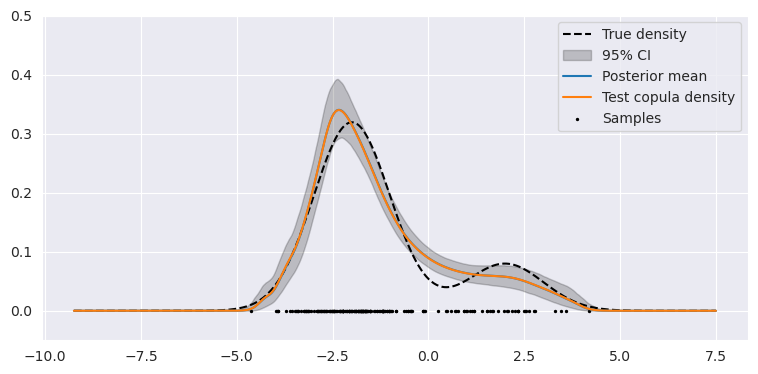

In [7]:
#@title Gaussian mixture model example
n = 200 # @param {type:"slider", min:10, max:500, step:5}
p_train = 0.8 # @param {type:"slider", min:0.05, max:0.95, step:0.01}
M = 30  # @param {type:"slider", min:10, max:500, step:5}
B = 500  # @param {type:"slider", min:10, max:500, step:5}
N = 1000  # @param {type:"slider", min:10, max:5000, step:5}
rho = 0.77 # @param {type:"slider", min:0.05, max:0.95, step:0.01}
locs = [-2, 2]
xmin, xmax = -9.25, 7.5
y_plot = np.linspace(xmin, xmax, 500)

# Samples
np.random.seed(42)
y = np.random.randn(n) + np.random.choice(locs, n, p=[p_train, 1 - p_train])
true_density = p_train * norm(locs[0]).pdf(y_plot) + (1 - p_train) * norm(locs[1]).pdf(
    y_plot
)

eps = 1e-3
cov = (rho * np.eye(2))[::-1] + np.eye(2)

def c_rho(P, P_y):
    phi_inv_u = norm.ppf(P)
    phi_inv_v = norm.ppf(P_y)

    copula_num = multivariate_normal(cov=cov).pdf(
        np.vstack((phi_inv_u, np.tile(phi_inv_v, len(P)))).T
    )
    copula_den = norm.pdf(phi_inv_u) * norm.pdf(phi_inv_v)

    return copula_num / copula_den


np.random.seed(42)
y_perm = np.vstack([np.random.choice(y, n, False) for _ in range(M)])

# Initial guess of p_0 and P_0
p_train = norm.pdf(y_perm)
P_train = norm.cdf(y_perm)
p_test = np.tile(norm.pdf(y_plot), (M, 1))
P_test = np.tile(norm.cdf(y_plot), (M, 1))

# Compute training data points predictive probabilities
for m in trange(M):
    for i in range(n):
        a_ip1 = (2 - 1 / (i + 1)) / (i + 1 + 1)

        p_y = p_train[m, i]
        P_y = P_train[m, i]

        # Update predictive density
        p_train[m] = (1 - a_ip1) * p_train[m] + a_ip1 * c_rho(
            P_train[m], P_y
        ) * p_train[m]
        p_test[m] = (1 - a_ip1) * p_test[m] + a_ip1 * c_rho(P_test[m], P_y) * p_test[m]

        # Update predictive probabilities
        H = norm.cdf(
            (norm.ppf(P_train[m]) - rho * norm.ppf(P_y)) / (1 - rho**2) ** 0.5
        )
        P_train[m] = (1 - a_ip1) * P_train[m] + a_ip1 * H
        H = norm.cdf(
            (norm.ppf(P_test[m]) - rho * norm.ppf(P_y)) / (1 - rho**2) ** 0.5
        )
        P_test[m] = (1 - a_ip1) * P_test[m] + a_ip1 * H

# We need to average over the permutations
p_test = p_test.mean(0)
P_test = P_test.mean(0)

# Predictive resampling
p_samples = np.tile(p_test, (B, 1))
P_samples = np.tile(P_test, (B, 1))

np.random.seed(42)
for b in trange(B):
    for i in range(N):
        a_ip1 = (2 - 1 / ((i + n) + 1)) / ((i + n) + 1 + 1)

        P_y = np.random.rand()

        p_samples[b] = (1 - a_ip1) * p_samples[b] + a_ip1 * c_rho(
            P_samples[b], P_y
        ) * p_samples[b]

        H = norm.cdf(
            (norm.ppf(P_samples[b]) - rho * norm.ppf(P_y)) / (1 - rho**2) ** 0.5
        )
        P_samples[b] = (1 - a_ip1) * P_samples[b] + a_ip1 * H


posterior_mean = p_samples.mean(0)
posterior_bot25 = np.percentile(p_samples, 2.5, axis=0)
posterior_top25 = np.percentile(p_samples, 97.5, axis=0)

plt.figure(None, 0.8 * plt.figaspect(0.5))
plt.plot(
    y_plot,
    true_density,
    label="True density",
    color="black",
    linestyle="--",
)
plt.fill_between(
    y_plot,
    posterior_top25,
    posterior_bot25,
    alpha=0.2,
    label="95% CI",
    color="k",
)
plt.plot(y_plot, posterior_mean, label="Posterior mean")
plt.plot(y_plot, p_test, label="Test copula density")
plt.scatter(y, np.zeros(n), 2, label="Samples", color="black")
plt.legend()
plt.ylim(-0.05, 0.5)
plt.tight_layout()
plt.show()

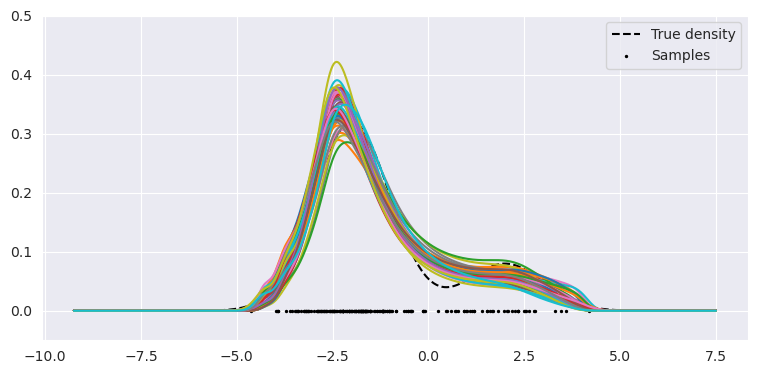

In [8]:
#@title Plot different samples from the posterior
plt.figure(None, 0.8 * plt.figaspect(0.5))
plt.plot(
    y_plot,
    true_density,
    label="True density",
    color="black",
    linestyle="--",
)
for b in range(50):
    plt.plot(y_plot, p_samples[b])
plt.scatter(y, np.zeros(n), 2, label="Samples", color="black")
plt.legend()
plt.ylim(-0.05, 0.5)
plt.tight_layout()
plt.show()